In [2]:
import os
import pandas as pd
import numpy as np
import pathlib
import xarray as xr
import rioxarray


In [3]:
import geopandas as gpd

#### step1: 读取原始数据(多边形——正方形 geojson，value为surge值)  
存储为dataset(nc)

##### step1-1:读取geojson原始文件

In [4]:
read_file_path: str = r"./../../data/zmax_center.json"
"""读取文件"""
data = gpd.read_file(read_file_path)

In [5]:
var_name='最大淹没深度(cm)'

In [6]:
surge_values = data[var_name].values

##### step1-2:将geojson读取的values，构建坐标  
`data.geometry.centroid` -> `.x`与`.y`

In [7]:
# 提取多边形的几何中心作为坐标
# 这里我们使用多边形的质心（centroid）作为代表坐标
centroids = data.geometry.centroid
latitudes = centroids.y
longitudes = centroids.x

# 创建一个xarray.Dataset
ds = xr.Dataset(
    {
        "surge": (("feature"), surge_values)
    },
    coords={
        "feature": np.arange(len(data)),
        "latitude": ("feature", latitudes),
        "longitude": ("feature", longitudes)
    }
)

C:\Users\evase\AppData\Local\Temp\ipykernel_298836\546687521.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = data.geometry.centroid


In [8]:
out_put_path:str='./../../data/zmax_1114.nc'

In [9]:
ds.to_netcdf(out_put_path)

----

##### step2-1: 按照geojson中的经纬度范围生成`np.nan`填充的网格数据dataset  
需要定义网格宽度`L`

In [10]:
from shapely.geometry import box

# 定义网格长宽
L = 0.0005  # 例如，0.001度的网格

# 获取整个区域的边界
minx, miny, maxx, maxy = data.total_bounds

# 生成网格
x_coords = np.arange(minx, maxx, L)
y_coords = np.arange(miny, maxy, L)

In [12]:
# 创建一个空的二维数组来存储网格数据
grid_data = np.full((len(y_coords), len(x_coords)), np.nan)

##### step2-2:优化效率

2min45s

In [14]:
import geopandas as gpd
import xarray as xr
import numpy as np
from shapely.geometry import box

# 读取GeoJSON文件
gdf = gpd.read_file(read_file_path)

# 定义网格长宽
L = L  # 例如，0.001度的网格

# 获取整个区域的边界
minx, miny, maxx, maxy = gdf.total_bounds

# 生成网格
x_coords = np.arange(minx, maxx, L)
y_coords = np.arange(miny, maxy, L)

# 创建一个空的二维数组来存储网格数据
grid_data = np.full((len(y_coords), len(x_coords)), np.nan)

# 创建空间索引
spatial_index = gdf.sindex

# 遍历网格
for i, x in enumerate(x_coords):
    for j, y in enumerate(y_coords):
        cell = box(x, y, x + L, y + L)
        
        # 使用空间索引查找可能相交的多边形
        possible_matches_index = list(spatial_index.intersection(cell.bounds))
        possible_matches = gdf.iloc[possible_matches_index]
        
        # 检查实际相交的多边形
        for _, row in possible_matches.iterrows():
            if row.geometry.intersects(cell):
                grid_data[j, i] = row[var_name]
                break  # 一旦找到一个相交的多边形，就可以退出循环

# 创建xarray.Dataset
ds = xr.Dataset(
    {
        "surge": (("y", "x"), grid_data)
    },
    coords={
        "x": x_coords,
        "y": y_coords
    }
)



In [15]:
out_put_path:str='./../../data/zmax_1114.nc'
ds.to_netcdf(out_put_path)

In [16]:
ds

<xarray.Dataset> Size: 4MB
Dimensions:  (y: 667, x: 731)
Coordinates:
  * x        (x) float64 6kB 121.4 121.4 121.4 121.4 ... 121.8 121.8 121.8 121.8
  * y        (y) float64 5kB 28.84 28.84 28.84 28.84 ... 29.17 29.17 29.17 29.17
Data variables:
    surge    (y, x) float64 4MB nan nan nan nan nan nan ... nan nan nan nan nan

In [17]:
# 检查纬度是否为降序
if not np.all(np.diff(ds['y'].values) < 0):
    # 如果不是降序，重新排序纬度
    ds = ds.sortby('y', ascending=False)

In [18]:
ds

<xarray.Dataset> Size: 4MB
Dimensions:  (y: 667, x: 731)
Coordinates:
  * x        (x) float64 6kB 121.4 121.4 121.4 121.4 ... 121.8 121.8 121.8 121.8
  * y        (y) float64 5kB 29.17 29.17 29.17 29.17 ... 28.84 28.84 28.84 28.84
Data variables:
    surge    (y, x) float64 4MB nan nan nan nan nan nan ... nan nan nan nan nan

In [19]:
out_put_path:str='./../../data/zmax_desc_1114.nc'
ds.to_netcdf(out_put_path)

#### step2: 将dataset 按照小于1.0，小于1.5进行筛选，并存储为geotiff

In [20]:
ds['surge'] = ds['surge'].where(ds['surge'] > 100, np.nan)

In [21]:
ds.to_netcdf('./../../data/zmax_lte_100.nc')

In [ ]:
import numpy as np
import xarray as xr
import rasterio
from rasterio.transform import from_origin

# 假设 ds 是之前创建并过滤后的 xarray.Dataset

# 获取坐标和数据
surge_data = ds['surge'].values
x_coords = ds['x'].values
y_coords = ds['y'].values

# 定义仿射变换
transform = from_origin(min(x_coords), max(y_coords), x_coords[1] - x_coords[0], y_coords[1] - y_coords[0])

# 定义元数据
meta = {
    'driver': 'GTiff',
    'dtype': 'float32',
    'nodata': np.nan,
    'width': len(x_coords),
    'height': len(y_coords),
    'count': 1,  # 单波段
    'crs': 'EPSG:4326',  # 假设使用WGS84坐标系
    'transform': transform
}

# 反转 y 轴的数据，因为 GeoTIFF 的原点在左上角
# TODO [-] 由于已经对原始数据对纬度进行降序排列，此处不需要再反转
# surge_data_flipped = np.flipud(surge_data)

# 写入 GeoTIFF 文件
with rasterio.open('./../../data/zmax_desc_lte_100.tif', 'w', **meta) as dst:
    dst.write(surge_data, 1)

In [25]:
lon=ds.coords['x']
lat=ds.coords['y']

In [26]:
lon_max=max(lon.values)
lon_min=min(lon.values)
lat_max=max(lat.values)
lat_min=min(lat.values)


step 3-2：生成边界并提取为多边形

In [57]:
from shapely.ops import unary_union
import numpy as np
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape, mapping
import json

In [58]:
data_array=ds['surge'].values

In [59]:
# 创建掩码，标识非 NaN 的区域
mask = ~np.isnan(data_array)

# 使用 rasterio 和 shapes 提取多边形
transform = rasterio.transform.from_bounds(lon_min, lat_min, lon_max, lat_max, len(lon), len(lat))


In [60]:

with rasterio.io.MemoryFile() as memfile:
    with memfile.open(
        driver='GTiff',
        height=data_array.shape[0],
        width=data_array.shape[1],
        count=1,
        dtype=data_array.dtype,
        crs='EPSG:4326',  # 使用 WGS84 坐标系
        transform=transform
    ) as dataset:
        dataset.write(data_array, 1)

        # 将栅格数据转换为矢量多边形
        results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) 
            in enumerate(shapes(data_array, mask=mask, transform=dataset.transform))
        )

        # 提取所有多边形
        polygons = [shape(feature['geometry']) for feature in results]

        # 合并多边形
        merged_polygon = unary_union(polygons)

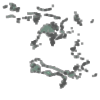

In [61]:
merged_polygon

In [ ]:
# 准备 GeoJSON 数据
geojson = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry": mapping(merged_polygon)
        }
    ]
}

# 保存为 GeoJSON 文件
with open('./../../data/zmax_lte_desc_100_1114.json', 'w') as f:
    json.dump(geojson, f)

# print("GeoJSON 文件已生成：output_polygon.geojson")

### step4 : 对多边形进行平滑处理

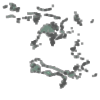

In [80]:
merged_polygon

In [84]:
len(polygons)

5500

In [106]:
def smooth_polygon(polygon, s=2):
    # 提取多边形的外环坐标
    x, y = polygon.exterior.coords.xy
    tck, u = splprep([x, y], s=0, per=True)  # per=True 使得多边形闭合
    unew = np.linspace(0, 1.0, len(x) * 100)  # 增加插值点数
    out = splev(unew, tck)
    source_polygon = Polygon(zip(out[0], out[1]))
    if source_polygon.is_valid == False:
        source_polygon = source_polygon.buffer(0)
    return source_polygon


# 对每个多边形进行平滑处理
smoothed_polygons = [smooth_polygon(poly) for poly in polygons]

In [107]:
merged_smoothed_polygons = unary_union(smoothed_polygons)

In [108]:
# 准备 GeoJSON 数据
geojson = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry": mapping(merged_smoothed_polygons)
        }
    ]
}


In [109]:
# TypeError: Object of type Polygon is not JSON serializable
# 保存为 GeoJSON 文件
with open('./../../data/zmax_lte_desc_smooth_100_b_100_1114.json', 'w') as f:
    json.dump(geojson, f)


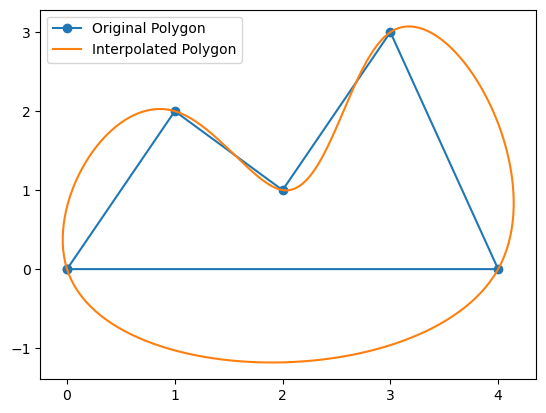

In [85]:
import numpy as np
from scipy.interpolate import splprep, splev
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

def interpolate_polygon(polygon, num_points=100):
    # 提取多边形的外环坐标
    x, y = polygon.exterior.coords.xy
    
    # 使用 splprep 进行 B样条插值
    tck, u = splprep([x, y], s=0, per=True)  # s=0 表示通过所有点，per=True 使得多边形闭合
    unew = np.linspace(0, 1.0, num_points)  # 在 0 到 1 之间生成 num_points 个新参数值
    out = splev(unew, tck)  # 计算插值点的坐标
    
    # 创建一个新的多边形
    return Polygon(zip(out[0], out[1]))

# 示例多边形
original_polygon = Polygon([(0, 0), (1, 2), (2, 1), (3, 3), (4, 0)])

# 对多边形进行插值
interpolated_polygon = interpolate_polygon(original_polygon, num_points=200)

# 绘制结果
plt.figure()
# 原始多边形
x, y = original_polygon.exterior.xy
plt.plot(x, y, 'o-', label='Original Polygon')

# 插值后的多边形
x, y = interpolated_polygon.exterior.xy
plt.plot(x, y, '-', label='Interpolated Polygon')

plt.legend()
plt.show()